In [1]:
import pandas as pd
import numpy as np
import random
import datetime as dt
from math import sqrt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler # 최대최소 스케일러
from sklearn.metrics import mean_squared_error # mse
from sklearn.metrics import r2_score # r2

#tensorflow 2.0
from tensorflow.keras.models import Sequential, load_model # 시퀀스 모델을 사용하기 위함
from tensorflow.keras.layers import Dense, Dropout # Dense, Dropout을 사용하기 위함
from tensorflow.keras.layers import LSTM # lstm을 사용하기 위함
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import RMSprop, Adam, Nadam
import tensorflow as tf


import joblib
import pickle
import os
import csv
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df_origin = pd.read_csv(r'C:\Users\rian\Documents\2023\01.OCI파워_예지정비\04.전처리\model_temp_20230209.csv', encoding='euc-kr')

In [3]:
df_origin['timestamp'] = pd.to_datetime(df_origin['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [4]:
df_origin['timestamp'] = pd.to_datetime(df_origin['timestamp'])

In [5]:
df_origin.set_index('timestamp', inplace=True)

In [6]:
df_origin.interpolate(method='linear', inplace=True)

In [7]:
df_origin.columns

Index(['tprt', 'rain', 'wdspd', 'hum', 'at_prs', 'shine', 'insol', 'snow',
       'cloud', 'PV_Voltage_Value', 'PV_Power_Value', 'PV_Current_Value',
       'Grid_Voltage_Value', 'Grid_Power_Value', 'year', 'month', 'day',
       'hour', 'min', 'Grid_Power_sum', 'PV_Power_sum', 'Grid_Power_rate',
       'PV_Power_rate', 'Average_Grid_Power'],
      dtype='object')

In [8]:
# df_deleted = df_origin[['tprt', 'rain', 'windspd', 'insol', 'Grid_Power_sum',
#                         'PV_Voltage_Value', 'Grid_Voltage_Value', 'Grid_Power_Value', 'hour']]

In [27]:
df_deleted = df_origin[['tprt', 'rain', 'wdspd', 'insol', 'hum', 'at_prs', 'shine', 'snow', 'cloud', # PV_Power_Value', # , 'Grid_Power_sum'
                        'PV_Voltage_Value', 'Grid_Voltage_Value', 'Grid_Power_Value', 'hour']] # , 'PV_Power_rate']]

In [10]:
def split_data(df):
    df.reset_index(drop=False, inplace=True)
    
    train_df = df.loc[df['timestamp'] < '2022-01-01']
    train_df.set_index('timestamp', inplace=True)
    train_x = train_df[[c for c in train_df.columns if c != 'Grid_Power_Value']].values
    train_y = train_df[['Grid_Power_Value']].values

    test_df = df.loc[df['timestamp'] >= '2022-01-01']
    test_df.set_index('timestamp', inplace=True)
    test_x = test_df[[c for c in test_df.columns if c != 'Grid_Power_Value']].values
    test_y = test_df[['Grid_Power_Value']].values
    
    return train_x, train_y, test_x, test_y

In [11]:
def scale_data(train_x, test_x):
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    train_x = train_x.reshape(-1, 1, train_x.shape[1])
    test_x = test_x.reshape(-1, 1, test_x.shape[1])
    return train_x, test_x, scaler

In [12]:
from math import cos, pi

In [13]:
def decayed_learning_rate(step):
    # 초기 학습률
    initial_learning_rate = 0.01
    # 최대 감쇠 횟수
    decay_steps = 100
    # 학습률 감쇠율 파라미터
    alpha = 0.01
    
    step = min(step, decay_steps)
    cosine_decay = 0.5 * (1 + cos(pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

In [14]:
def set_model(train_x, train_y):
#     cos_decay = tf.keras.experimental.CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=alpha)
    
    model = Sequential() # 시퀀스 데이터 사용할 모델
    model.add(LSTM(64, activation = 'tanh', input_shape=(1, train_x.shape[2]))) # , return_sequences=True) # lstm모델 설정(층 : 60, 활성함수 : 'tanh', 입력 데이터 형태(input_shape)
    model.add(Dense(1, activation = 'linear')) # dense 설정(활성함수 = 'linear')
    # 64 Nadam 0.0001 : 8.025
    model.compile(loss='mean_absolute_error', optimizer=Nadam(), metrics=['mae']) # 모델 컴파일(오차함수 : loss, 옵티마이저 = 'adam', )
    lr_scheduler = LearningRateScheduler(decayed_learning_rate , verbose=1)
    model.summary()
    print('loss:오차  - acc:  - mae:  - val_loss:  - val_mae: ')
    
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
    model.fit(train_x, train_y, epochs=1000, batch_size=32, verbose=2, shuffle=False, callbacks=[lr_scheduler, early_stop])
    
    return model

In [15]:
def eval_result(train_x, test_x, train_y, test_y, model, scaler):
    xhat = model.predict(train_x)
    yhat = model.predict(test_x) # 검증 데이터X 예측
    
    # invert scaling for forecast
    if len(train_x.shape) >= 3:
        train_x = train_x.reshape(train_x.shape[0], train_x.shape[2])
        test_x = test_x.reshape(test_x.shape[0], test_x.shape[2])
    else:
        xhat = xhat.reshape(-1, 1)
        yhat = yhat.reshape(-1, 1)
        
    train_x = scaler.inverse_transform(train_x)
    inv_xhat = np.concatenate((train_x, xhat), axis=1)
    inv_xhat = inv_xhat[:, -xhat.shape[-1]:]
    inv_xhat = inv_xhat.reshape(-1, 1)

    
    test_x = scaler.inverse_transform(test_x)
    inv_yhat = np.concatenate((test_x, yhat), axis=1)
    inv_yhat = inv_yhat[:, -xhat.shape[-1]:]
    inv_yhat = inv_yhat.reshape(-1, 1)

    inv_x = np.concatenate((train_x, train_y), axis=1)
    inv_x = inv_x[:, -train_y.shape[-1]:]
    inv_x = inv_x.reshape(-1, 1)

    inv_y = np.concatenate((test_x, test_y), axis=1)
    inv_y = inv_y[:, -test_y.shape[-1]:]
    inv_y = inv_y.reshape(-1, 1)

    # 결과 출력
    # calculate RMSE
    trainRMSE = sqrt(mean_squared_error(inv_x, inv_xhat))
    trainR2 = r2_score(inv_x, inv_xhat)
    print('Train RMSE : %.3f' % trainRMSE)
    print('Train R2 : %.3f' % trainR2)
    testRMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
    testR2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE : %.3f' % testRMSE)
    print('Test R2 : %.3f' % testR2)
    eval_[column] = [trainRMSE, trainR2, testRMSE, testR2]
    
    return inv_y, inv_yhat, xhat, yhat

In [16]:
def make_plot(inv_y, inv_yhat):
    # inv_y = inv_y.reshape(len(past), -1)
    # inv_yhat = inv_yhat.reshape(len(past), -1)

    # plt.style.use('default')
    # plot baseline and prediction 실제, 예측, 검증 데이터 관련 그래프
    sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='whitegrid')
    sns.lineplot(inv_y[:, -1], linewidth=2.5, color='steelblue', label='실제')
    sns.lineplot(inv_yhat[:, -1], linewidth=2.5, color='darkorange', label='검증')
    plt.xlabel('날짜', fontsize='15')
    plt.ylabel('  ', fontsize='15')

    #     plt.grid()
    plt.legend()
    plt.show()

In [17]:
def scale_data(df):
    org_col = df.columns
    org_idx = df.index
    scaler = MinMaxScaler()
    scale_df = df.iloc[:, :-1]
    target_df = df.iloc[:, -1].values.reshape(-1, 1)
    scaled_df = scaler.fit_transform(scale_df)
    scaled_df = pd.DataFrame(np.concatenate((scaled_df, target_df), axis=1))
    scaled_df.columns = org_col
    scaled_df.set_index(org_idx, inplace=True)
    return scaled_df, scaler

In [18]:
def shift_data(df):
    df = df[[c for c in df.columns if c != 'Grid_Power_Value'] + ['Grid_Power_Value']]
    org_idx = df.index
    df.reset_index(drop=True, inplace=True)

    temp = []
    temp_col = []
    for i in range(5, -1, -1):
        temp.append(df.shift(i))
        temp_col += [f'{c}_{i}' for c in df.columns]
    shifted_df = pd.DataFrame(pd.concat(temp, axis=1))
    shifted_df.columns = temp_col
    shifted_df.set_index(org_idx[:shifted_df.shape[0]+1], inplace=True)
    return shifted_df

In [28]:
del model

========== lstm ==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                36352     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 36,417
Trainable params: 36,417
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_mae: 

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/1000
1643/1643 - 5s - loss: 64.0184 - mae: 64.0184 - lr: 0.0100 - 5s/epoch - 3ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.009997557473810372.
Epoch 2/1000
1643/1643 - 3s - loss: 25.3084 - mae: 25.3084 - lr: 0.0100 - 3s/epoch - 2ms/step

Epoch 3: LearningRateScheduler setting

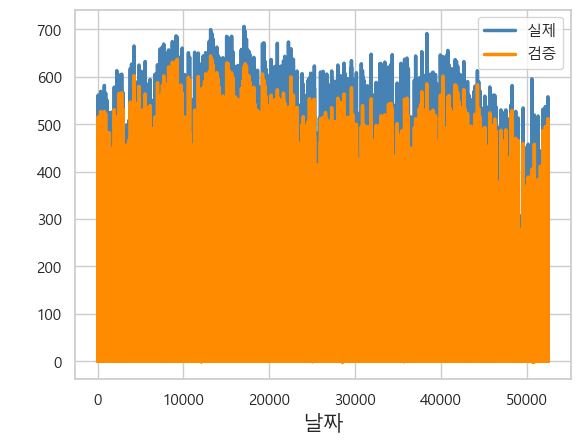

In [29]:
num = 0

eval_ = {}
df = df_deleted.copy()
print('='*10, 'lstm', '='*10)
shifted_df = shift_data(df.copy())

scaled_df, scaler = scale_data(shifted_df.copy())

train_df = scaled_df[scaled_df.index < '2022-01-01'].dropna(axis=0)
test_df = scaled_df[scaled_df.index >= '2022-01-01'].dropna(axis=0)

train_x = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

test_x = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]

model = set_model(train_x.copy().values.reshape(train_x.shape[0], -1, train_x.shape[1]), train_y.copy().values)

column = 'org'
inv_y, inv_yhat, xhat, yhat = eval_result(train_x.copy().values.reshape(train_x.shape[0], -1, train_x.shape[1]),
                                          test_x.copy().values.reshape(test_x.shape[0], -1, test_x.shape[1]),
                                          train_y.copy().values.reshape(-1, 1),
                                          test_y.copy().values.reshape(-1, 1), model, scaler)

temp = df_origin.copy().iloc[5:, :]
temp['pred'] = np.concatenate((xhat, yhat), axis=0)
temp['abs_err'] = abs(temp['Grid_Power_Value'] - temp['pred'])
temp['anomaly_score'] = round(temp['abs_err'] / temp['Grid_Power_Value'], 4)
inf_idx = temp[(temp['anomaly_score'] == float('inf')) | (temp['anomaly_score'] == float('-inf'))].index.tolist()

# 해가 떠있을 시간인데, 출력값이 0인 경우
inf_idx += temp[(temp['Grid_Power_Value'] <= 0.0) & ((temp['hour'] >= 9) | (temp['hour'] <= 18))].index.tolist()
temp.loc[inf_idx, 'anomaly_score'] = float(0.0)

mms = MinMaxScaler()
temp['anomaly_score'] = mms.fit_transform(temp['anomaly_score'].values.reshape(-1, 1))
temp.loc[inf_idx, 'anomaly_score'] = float(999.0)
temp.loc[temp[(temp['Grid_Power_Value'] <= 0.0) & ((temp['hour'] < 9) | (temp['hour'] > 18))].index, 'anomaly_score'] = float(-1.0)
temp['anomaly'] = ['anomaly_detected' if (v >= 0.002) else 'no_power' if v <= -1.0 else 'no_detected' for v in temp['anomaly_score']]
temp.reset_index(drop=False, inplace=True)
temp.to_csv(r'C:\Users\rian\Documents\2023\01.OCI파워_예지정비\04.전처리\lstm_test_{0}_{1}.csv'.format(num, dt.datetime.strftime(dt.datetime.now().date(), format='%Y%m%d')), encoding='euc-kr', index=False)

# del train_x
# del train_y
# del test_x
# del test_y
# del model
# del scaler
# del temp

make_plot(inv_y, inv_yhat)
# num += 1

In [22]:
# PV_Volage_Value <= 750.0 |
# PV_Current_Value <= 9.0
# Grid_Power_Value <= 0.0
# 얘는 이상치가 아님
# low_energy로 라벨링

tprt
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 38.014
Test R2 : 0.961


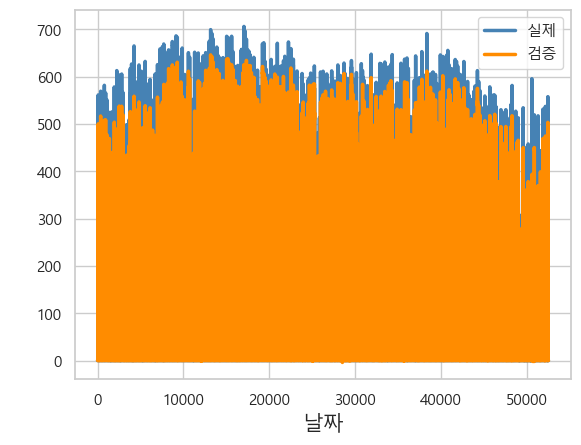

rain
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 38.943
Test R2 : 0.959


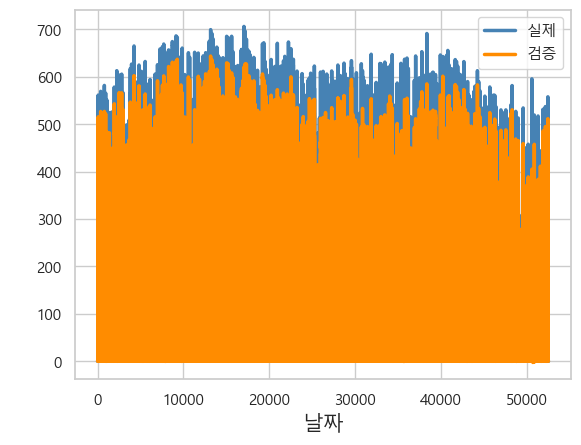

wdspd
1643/1643 [==============================] - 3s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 38.844
Test R2 : 0.959


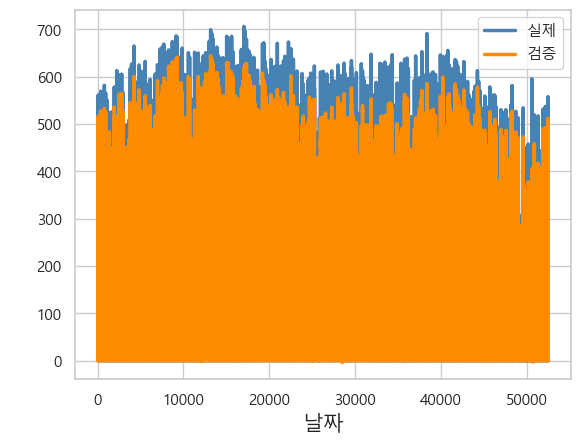

insol
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 47.331
Test R2 : 0.940


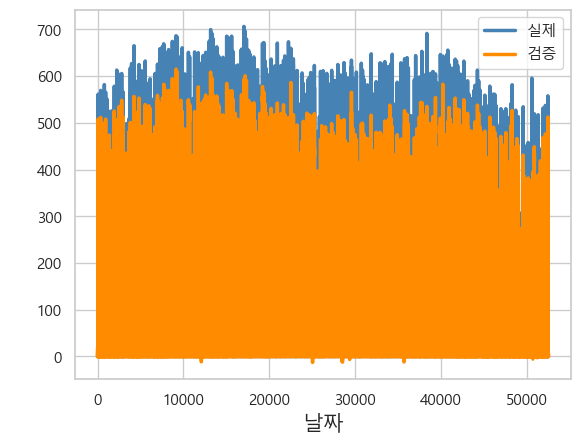

hum
1643/1643 [==============================] - 3s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 39.295
Test R2 : 0.959


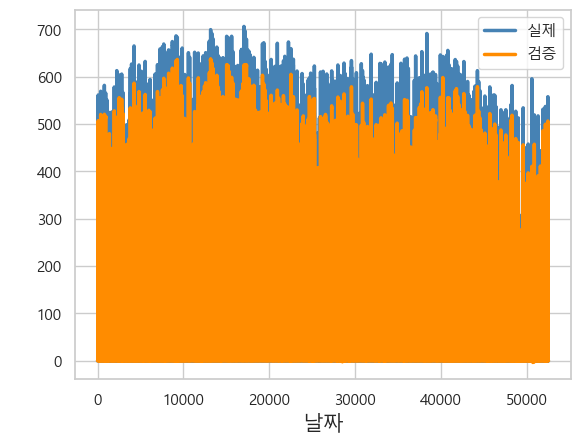

at_prs
1643/1643 [==============================] - 3s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 39.132
Test R2 : 0.959


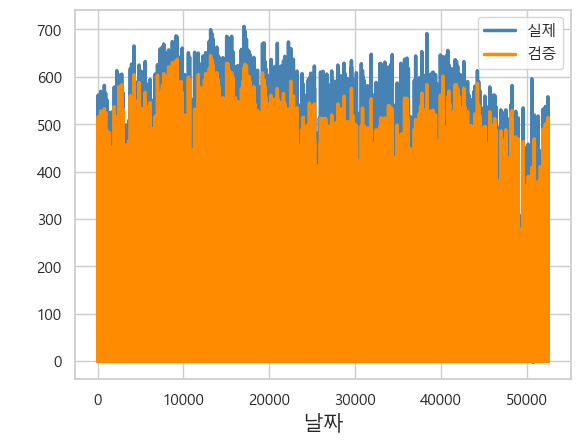

shine
1643/1643 [==============================] - 3s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 35.566
Test R2 : 0.966


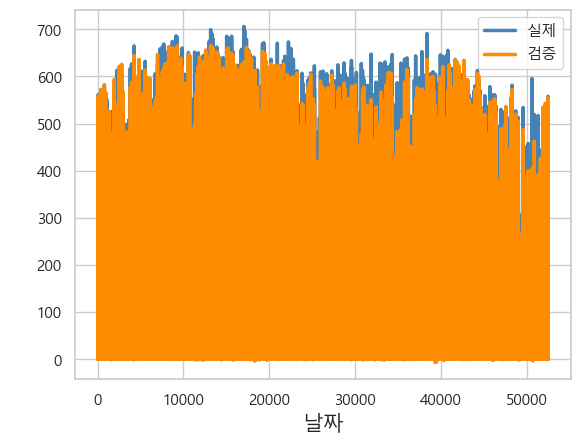

snow
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 39.271
Test R2 : 0.959


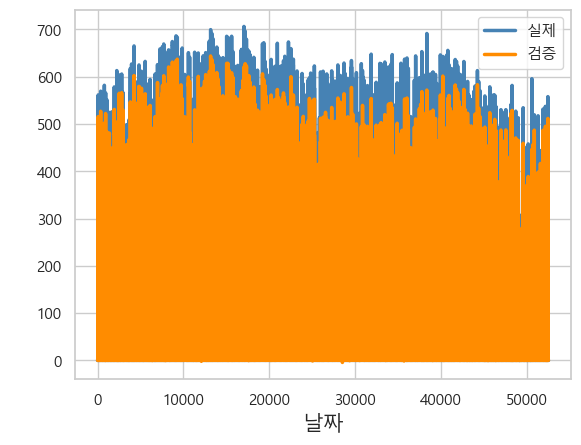

cloud
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 39.721
Test R2 : 0.958


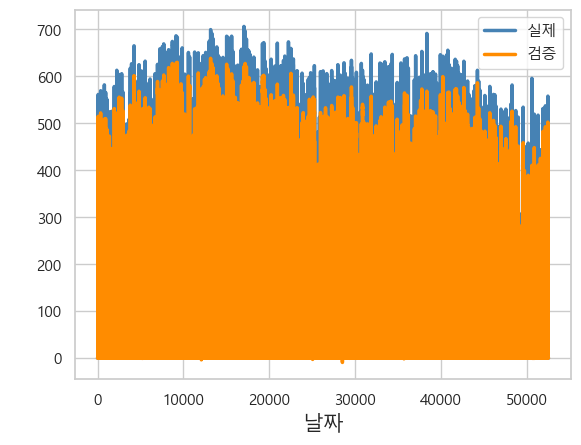

PV_Voltage_Value
1643/1643 [==============================] - 2s 1ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 42.810
Test R2 : 0.951


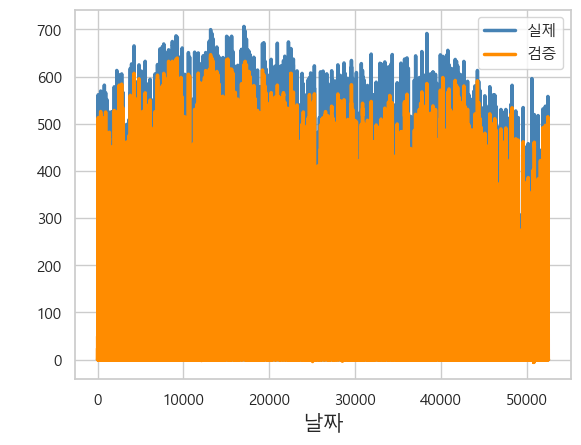

Grid_Voltage_Value
1643/1643 [==============================] - 3s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 39.240
Test R2 : 0.959


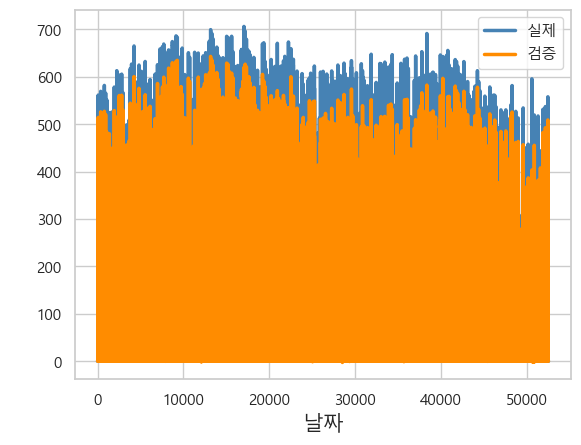

hour
1643/1643 [==============================] - 4s 2ms/step
Train RMSE : 40.623
Train R2 : 0.954
Test RMSE : 43.703
Test R2 : 0.949


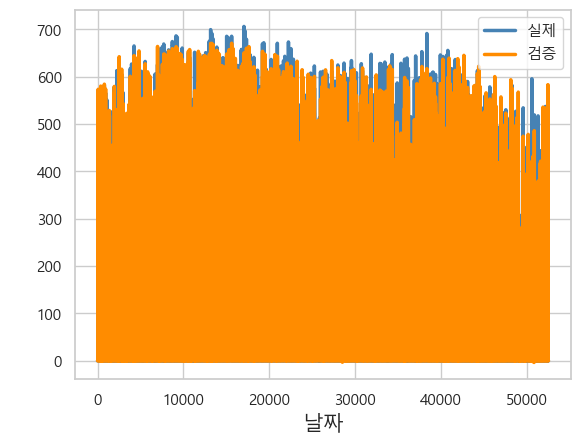

In [30]:
for c in [d for d in df.columns if d != 'Grid_Power_Value']:
    column = c
    print(column)
    temp_test = test_df.copy()
    
    for v in temp_test.filter(like=column).columns:
        temp_test[v] = random.sample(temp_test[v].values.tolist(), k=temp_test.shape[0])
        
    test_temp_x = temp_test.iloc[:, :-1]

    inv_temp_y, inv_temp_yhat, xhat_temp, yhat_temp = eval_result(train_x.copy().values.reshape(train_x.shape[0], -1, train_x.shape[1]),
                                          test_temp_x.copy().values.reshape(test_temp_x.shape[0], -1, test_temp_x.shape[1]),
                                          train_y.copy().values.reshape(-1, 1),
                                          test_y.copy().values.reshape(-1, 1), model, scaler)

    make_plot(inv_temp_y, yhat_temp)

<AxesSubplot: xlabel='importance'>

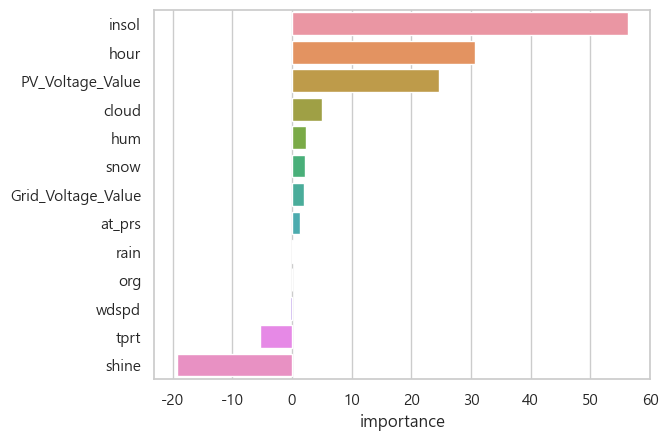

In [31]:
evaluated = pd.DataFrame(eval_).T
evaluated.columns = ['trainRMSE', 'trainR2', 'testRMSE', 'testR2']
evaluated['importance'] = round(evaluated.loc['org', 'testR2'] - evaluated['testR2'], 5)
evaluated['importance'] = evaluated['importance'] / sum(evaluated['importance']) * 100
evaluated.sort_values('testR2', inplace=True)
sns.barplot(y=evaluated['importance'].index, x=evaluated['importance'])

In [32]:
evaluated

,trainRMSE,trainR2,testRMSE,testR2,importance
insol,40.623015,0.953546,47.330636,0.939828,56.286044
hour,40.623015,0.953546,43.702616,0.948699,30.709343
PV_Voltage_Value,40.623015,0.953546,42.809816,0.950774,24.711649
cloud,40.623015,0.953546,39.720656,0.957622,4.959631
hum,40.623015,0.953546,39.294934,0.958525,2.364475
snow,40.623015,0.953546,39.271197,0.958575,2.220300
Grid_Voltage_Value,40.623015,0.953546,39.240462,0.958640,2.047290
at_prs,40.623015,0.953546,39.132020,0.958869,1.384083
rain,40.623015,0.953546,38.943371,0.959264,0.230681
org,40.623015,0.953546,38.904056,0.959346,0.000000


In [ ]:
# PV_Volage_Value <= 750.0 |
# PV_Current_Value <= 9.0
# Grid_Power_Value <= 0.0
# 얘는 이상치가 아님
# low_energy로 라벨링

In [36]:
temp = df_origin.copy().iloc[5:, :]
temp['pred'] = np.concatenate((xhat, yhat), axis=0)
temp['abs_err'] = abs(temp['Grid_Power_Value'] - temp['pred'])
temp['anomaly_score'] = round(temp['abs_err'] / temp['Grid_Power_Value'], 4)
inf_idx = temp[(temp['anomaly_score'] == float('inf')) | (temp['anomaly_score'] == float('-inf'))].index.tolist()

# 해가 떠있을 시간인데, 출력값이 0인 경우
inf_idx += temp[(temp['Grid_Power_Value'] <= 0.0) & ((temp['hour'] >= 9) | (temp['hour'] <= 18))].index.tolist()
temp.loc[inf_idx, 'anomaly_score'] = float(0.0)

mms = MinMaxScaler()
temp['anomaly_score'] = mms.fit_transform(temp['anomaly_score'].values.reshape(-1, 1))
temp.loc[inf_idx, 'anomaly_score'] = float(999.0)
temp.loc[temp[(temp['Grid_Power_Value'] <= 0.0) & ((temp['hour'] < 9) | (temp['hour'] > 18))].index, 'anomaly_score'] = float(-1.0)
temp['anomaly'] = ['anomaly_detected' if (v >= 0.002) else 'no_power' if v <= -1.0 else 'no_detected' for v in temp['anomaly_score']]
temp.reset_index(drop=False, inplace=True)
temp.to_csv(r'C:\Users\rian\Documents\2023\01.OCI파워_예지정비\04.전처리\lstm_shifted_{0}_v2.0.csv'.format(dt.datetime.strftime(dt.datetime.now().date(), format='%Y%m%d')), encoding='euc-kr', index=False)

In [75]:
temp = df_origin.copy().iloc[5:, :]
temp['pred'] = np.concatenate((xhat, yhat), axis=0)
temp['abs_err'] = abs(temp['Grid_Power_Value'] - temp['pred'])
temp['anomaly_score'] = round(temp['abs_err'] / temp['Grid_Power_Value'], 4)
inf_idx = temp[(temp['anomaly_score'] == float('inf')) | (temp['anomaly_score'] == float('-inf'))].index.tolist()

# 전압, 전력값 등이 낮아 Grid Power도 낮은 경우
low_idx = temp[((temp['PV_Voltage_Value'] <= 750.0) | (temp['PV_Current_Value'] <= 9.0))
               & ((temp['Grid_Power_Value'] <= 0.0) & (temp['hour'] >= 9) & (temp['hour'] <= 18))].index.tolist()

# Grid Power가 가능한데 0 이하인 경우
inf_idx += temp[((temp['PV_Voltage_Value'] > 750.0) & (temp['PV_Current_Value'] > 9.0))
               & ((temp['Grid_Power_Value'] <= 0.0) & (temp['hour'] >= 9) & (temp['hour'] <= 18))].index.tolist()
temp.loc[inf_idx, 'anomaly_score'] = float(0.0)

mms = MinMaxScaler()
temp['anomaly_score'] = mms.fit_transform(temp['anomaly_score'].values.reshape(-1, 1))
temp.loc[inf_idx, 'anomaly_score'] = float(999.0)
temp.loc[temp[(temp['Grid_Power_Value'] <= 0.0) & ((temp['hour'] < 9) | (temp['hour'] > 18))].index, 'anomaly_score'] = float(-1.0)
temp['anomaly'] = ['anomaly_detected' if (v >= 0.002) else 'no_power' if v <= -1.0 else 'no_detected' for v in temp['anomaly_score']]
temp.loc[low_idx, 'anomaly_score'] = float(0.0)
temp.loc[low_idx, 'anomaly'] = 'no_detected'

temp.reset_index(drop=False, inplace=True)
temp.to_csv(r'C:\Users\rian\Documents\2023\01.OCI파워_예지정비\04.전처리\lstm_shifted_{0}_v2.1.csv'.format(dt.datetime.strftime(dt.datetime.now().date(), format='%Y%m%d')), encoding='euc-kr', index=False)

In [77]:
temp.loc[(temp['Grid_Power_Value'] <= 0.0) & (temp['hour'] >= 9) & (temp['hour'] <= 18)]

,timestamp,tprt,rain,wdspd,hum,at_prs,shine,insol,snow,cloud,...,min,Grid_Power_sum,PV_Power_sum,Grid_Power_rate,PV_Power_rate,Average_Grid_Power,pred,abs_err,anomaly_score,anomaly
93,2021-01-01 16:20:00,3.2,0.0,3.6,53.0,1020.4,0.4,0.1750,0.0,7.0,...,20.0,9532.2,9084.5,0.0,0.026976,0.0,26.171558,26.171558,999.0,anomaly_detected
99,2021-01-01 17:20:00,3.2,0.0,4.3,53.0,1020.2,0.4,0.0944,0.0,6.0,...,20.0,9769.8,9257.1,0.0,0.019298,0.0,5.708187,5.708187,0.0,no_detected
100,2021-01-01 17:30:00,3.2,0.0,4.3,53.0,1020.2,0.4,0.0944,0.0,6.0,...,30.0,9771.2,9257.1,0.0,0.001243,0.0,-0.031140,0.031140,0.0,no_detected
101,2021-01-01 17:40:00,3.2,0.0,4.3,53.0,1020.2,0.4,0.0944,0.0,6.0,...,40.0,9771.4,9257.1,0.0,0.000195,0.0,0.020163,0.020163,0.0,no_detected
102,2021-01-01 17:50:00,3.2,0.0,4.3,53.0,1020.2,0.4,0.0944,0.0,6.0,...,50.0,9771.6,9257.1,0.0,0.000208,0.0,-0.013060,0.013060,0.0,no_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105080,2022-12-31 18:10:00,3.7,0.0,2.8,57.0,1025.5,0.3,0.0139,0.0,0.0,...,10.0,18954.9,18322.9,0.0,0.001498,0.0,0.102396,0.102396,0.0,no_detected
105081,2022-12-31 18:20:00,3.7,0.0,2.8,57.0,1025.5,0.3,0.0139,0.0,0.0,...,20.0,18954.9,18322.9,0.0,0.000000,0.0,0.089550,0.089550,0.0,no_detected
105082,2022-12-31 18:30:00,3.7,0.0,2.8,57.0,1025.5,0.3,0.0139,0.0,0.0,...,30.0,18954.9,18322.9,0.0,0.000000,0.0,0.011618,0.011618,0.0,no_detected
105083,2022-12-31 18:40:00,3.7,0.0,2.8,57.0,1025.5,0.3,0.0139,0.0,0.0,...,40.0,18954.9,18322.9,0.0,0.000000,0.0,0.006552,0.006552,0.0,no_detected
